# Projekt Dno Oka
## Autorzy
- Jędrzej Warczyński 148234
- Uladzislau Abeziuk 150243

## Dane
https://www5.cs.fau.de/research/data/fundus-images/

## Wykorzystywane biblioteki

In [1]:
import cv2
import numpy as np
from skimage import filters, morphology

from tqdm import tqdm

from python_files.metrics_visualizer import MetricsVisualizer
from python_files.constants import *

## Progowanie obrazu

In [2]:
def threshold_image(image, threshold):
    thresholded_image = np.where(image < threshold, 0, 255)
    return thresholded_image

## Wstępne przetworzenie danych
- ekstrakcja składowje zielonej
- zastosowanie rozmycia medianowego
- zastosowanie normalizacji histogramu

In [3]:
def preprocess(image):
    _, green_chanel, _ = cv2.split(image)
    img = cv2.medianBlur(green_chanel, 7)

    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(7, 7))
    img = clahe.apply(img)

    return img

## Właściwe przetworzenie obrazu (filtr Frangiego)

In [4]:
def process_image(preprocessed_img):
    img = filters.frangi(preprocessed_img, gamma=0.8, beta=0.15)
    img = (img * 255).astype(np.uint8)
    return img

## Postprocessing
- progowanie
- usunięcie małych obiektów
- otwarcie
- rozymice medianowe

In [6]:
def post_process_image(processed_img):
    img = cv2.medianBlur(processed_img, 3)
    img = threshold_image(img, 35)
    img = np.array(img, bool)
    img = morphology.remove_small_objects(img, min_size=128)*255
    img = img.astype(np.uint8)
    
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = img.astype(np.uint8)

    return img

## Zastosowanie maski pola widzenia

In [7]:
def apply_fov_mask(img, fov_mask):
    img = cv2.bitwise_and(img, img, mask=fov_mask.astype(np.uint8))
    return img

## Segmentacja naczyń
- wstępne przetworzenie obrazu
- właściwe przetworzenie obrazu
- postprocessing
- zastosowanie maski pola widzenia

In [8]:
def segment_vessels(image, fov_mask):
    preprocessed_img = preprocess(image)
    processed_img = process_image(preprocessed_img)
    postprocessed_img = post_process_image(processed_img)
    segmentation_mask = apply_fov_mask(postprocessed_img, fov_mask)
    return segmentation_mask

## Obliczenie maski błędnie sklasyfikowanych pikseli

In [9]:
def calculate_misclassified_mask(segmentation_mask, expert_mask):
    misclassified_mask = np.zeros((*segmentation_mask.shape, 3), dtype=np.uint8)
    misclassified_mask[np.logical_and(segmentation_mask > 128, expert_mask <= 128)] = [255, 0, 0]
    misclassified_mask[np.logical_and(segmentation_mask > 128, expert_mask > 128)] = [255, 255, 255]
    # misclassified_mask[np.logical_and(segmentation_mask > 128, expert_mask > 128)] = [0, 255, 0]
    misclassified_mask[np.logical_and(segmentation_mask < 128, expert_mask > 128)] = [0, 0, 255]
    return misclassified_mask

## Wczytanie obrazu i segmentacja

In [9]:
metrics_visualizer = MetricsVisualizer()
for file_name in tqdm(file_names[:5], total=5):
    image_path = os.path.join(IMAGES_FOLDER, file_name)
    image = cv2.imread(image_path)

    mask_path = os.path.join(MANUAL_FOLDER, file_name.split('.')[0] + '.tif')
    expert_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fov_mask_path = os.path.join(MASK_FOLDER, file_name.split('.')[0] + '_mask.tif')
    fov_mask = cv2.imread(fov_mask_path, cv2.IMREAD_GRAYSCALE)

    segmentation_mask = segment_vessels(image, fov_mask)
    metrics_visualizer.calculate_metrics(expert_mask, segmentation_mask, file_name)

100%|██████████| 5/5 [01:32<00:00, 18.42s/it]


## Wizualizacja metryk

Image        Accuracy    Sensitivity    Specificity      TP           TN      FP      FN
---------  ----------  -------------  -------------  ------  -----------  ------  ------
01_dr.JPG    0.952292       0.713653       0.965079  297081  7.49776e+06  271302  119201
01_g.jpg     0.954851       0.71641        0.971947  392329  7.42345e+06  214261  155303
01_h.jpg     0.953848       0.730201       0.979216  608906  7.19866e+06  152791  224982
02_dr.JPG    0.949832       0.676796       0.968426  353205  7.4215e+06   241967  168673
02_g.jpg     0.950567       0.692179       0.971363  422037  7.35868e+06  216940  187685
mean         0.952278       0.705848       0.971206  414712  7.38001e+06  219452  171169


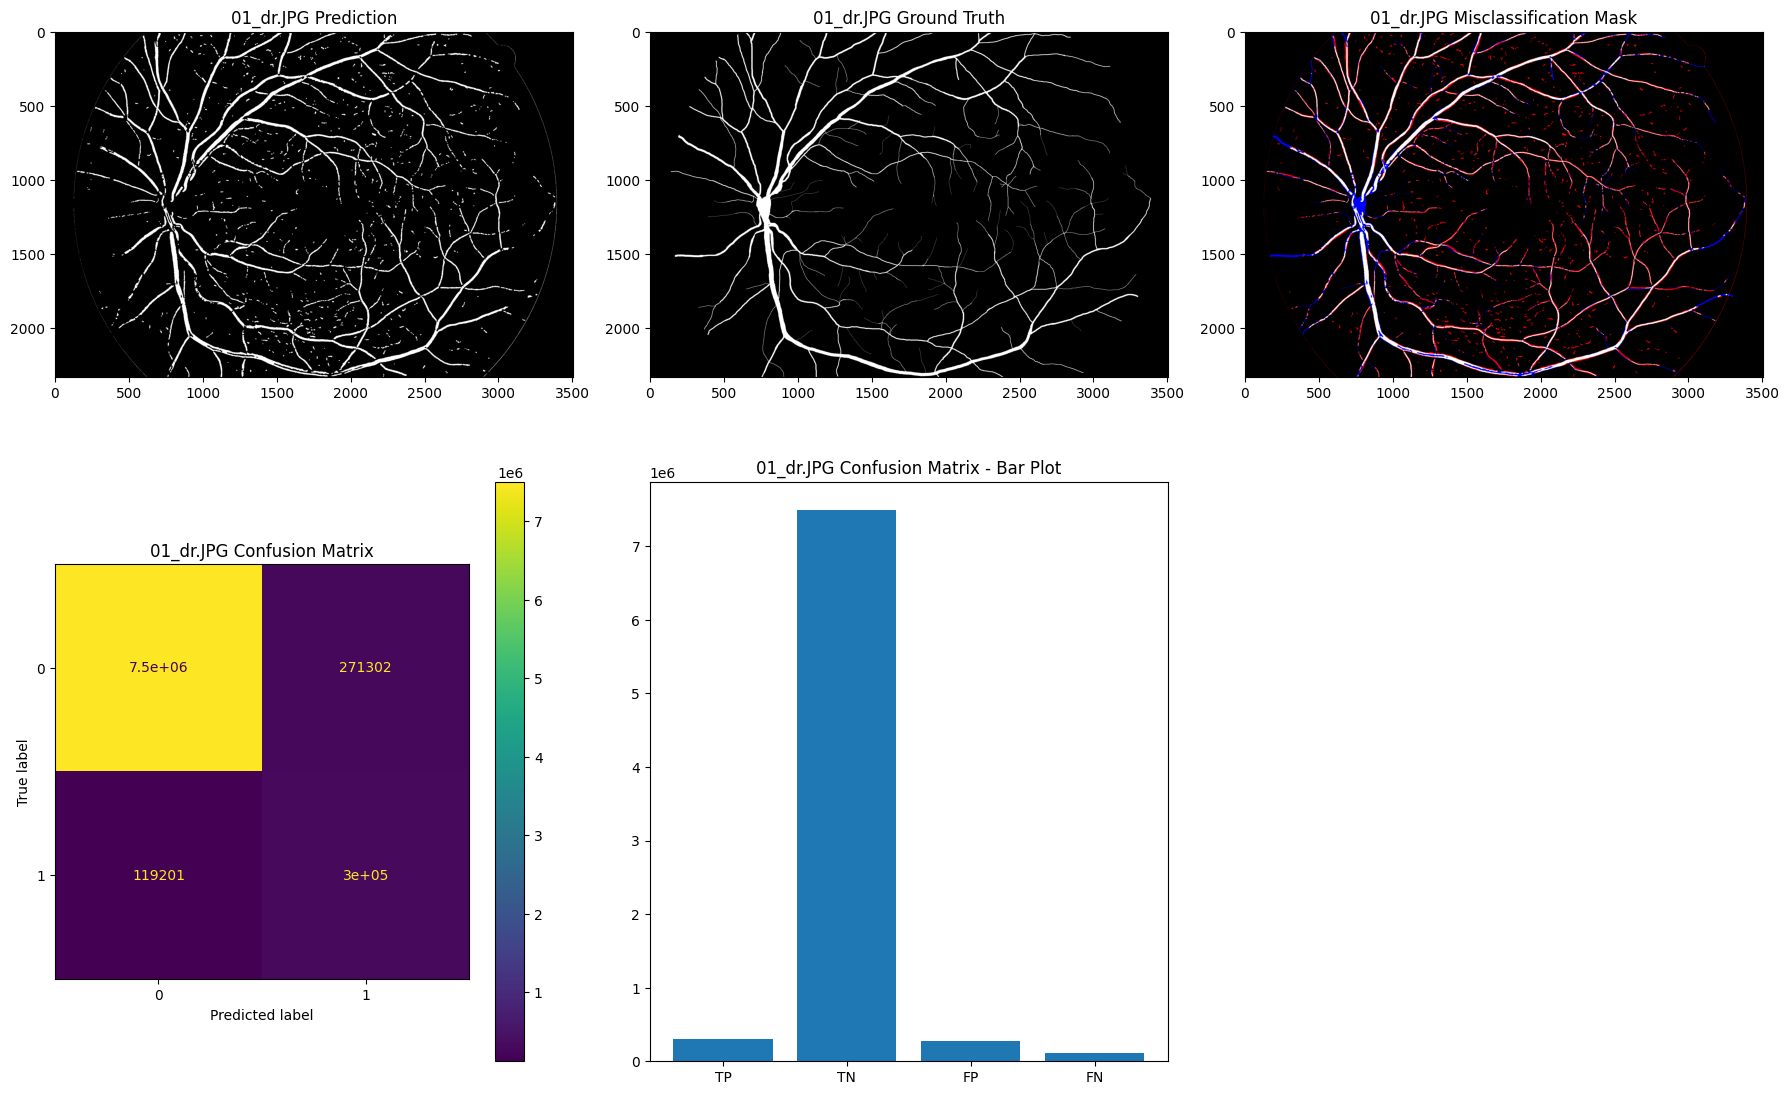

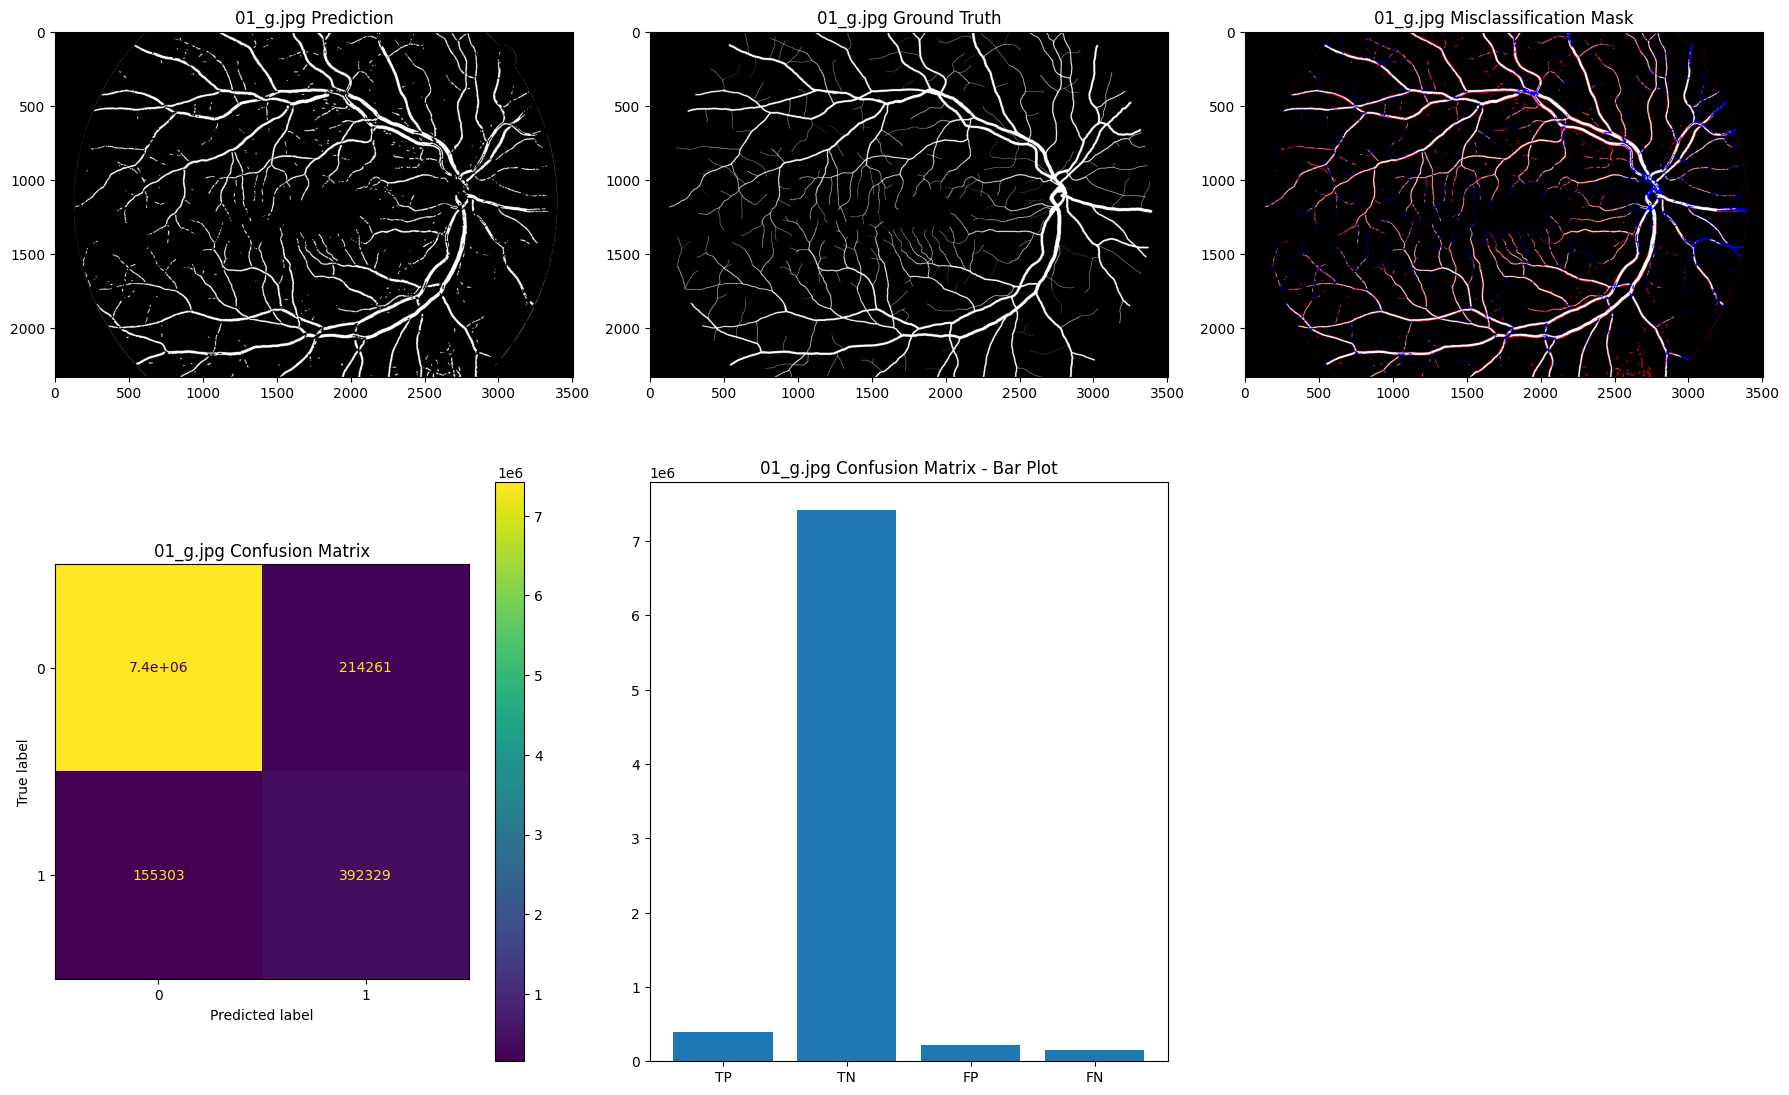

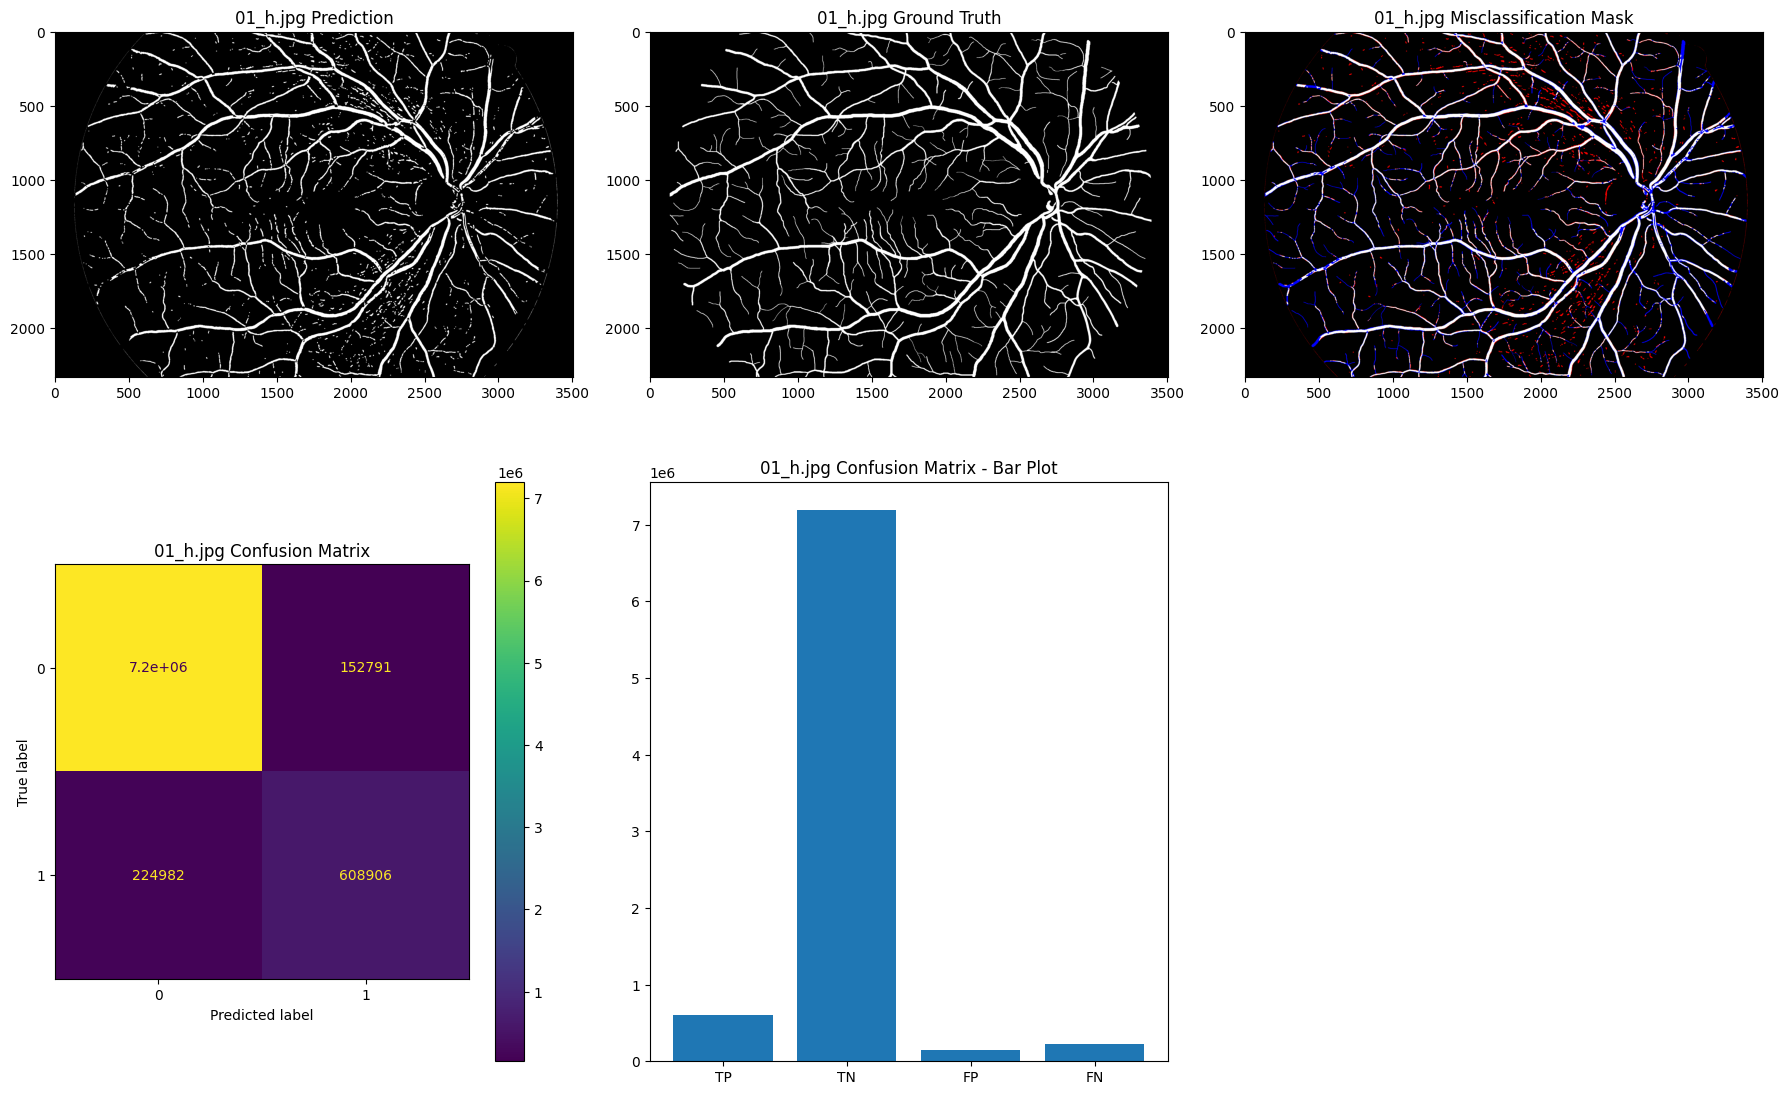

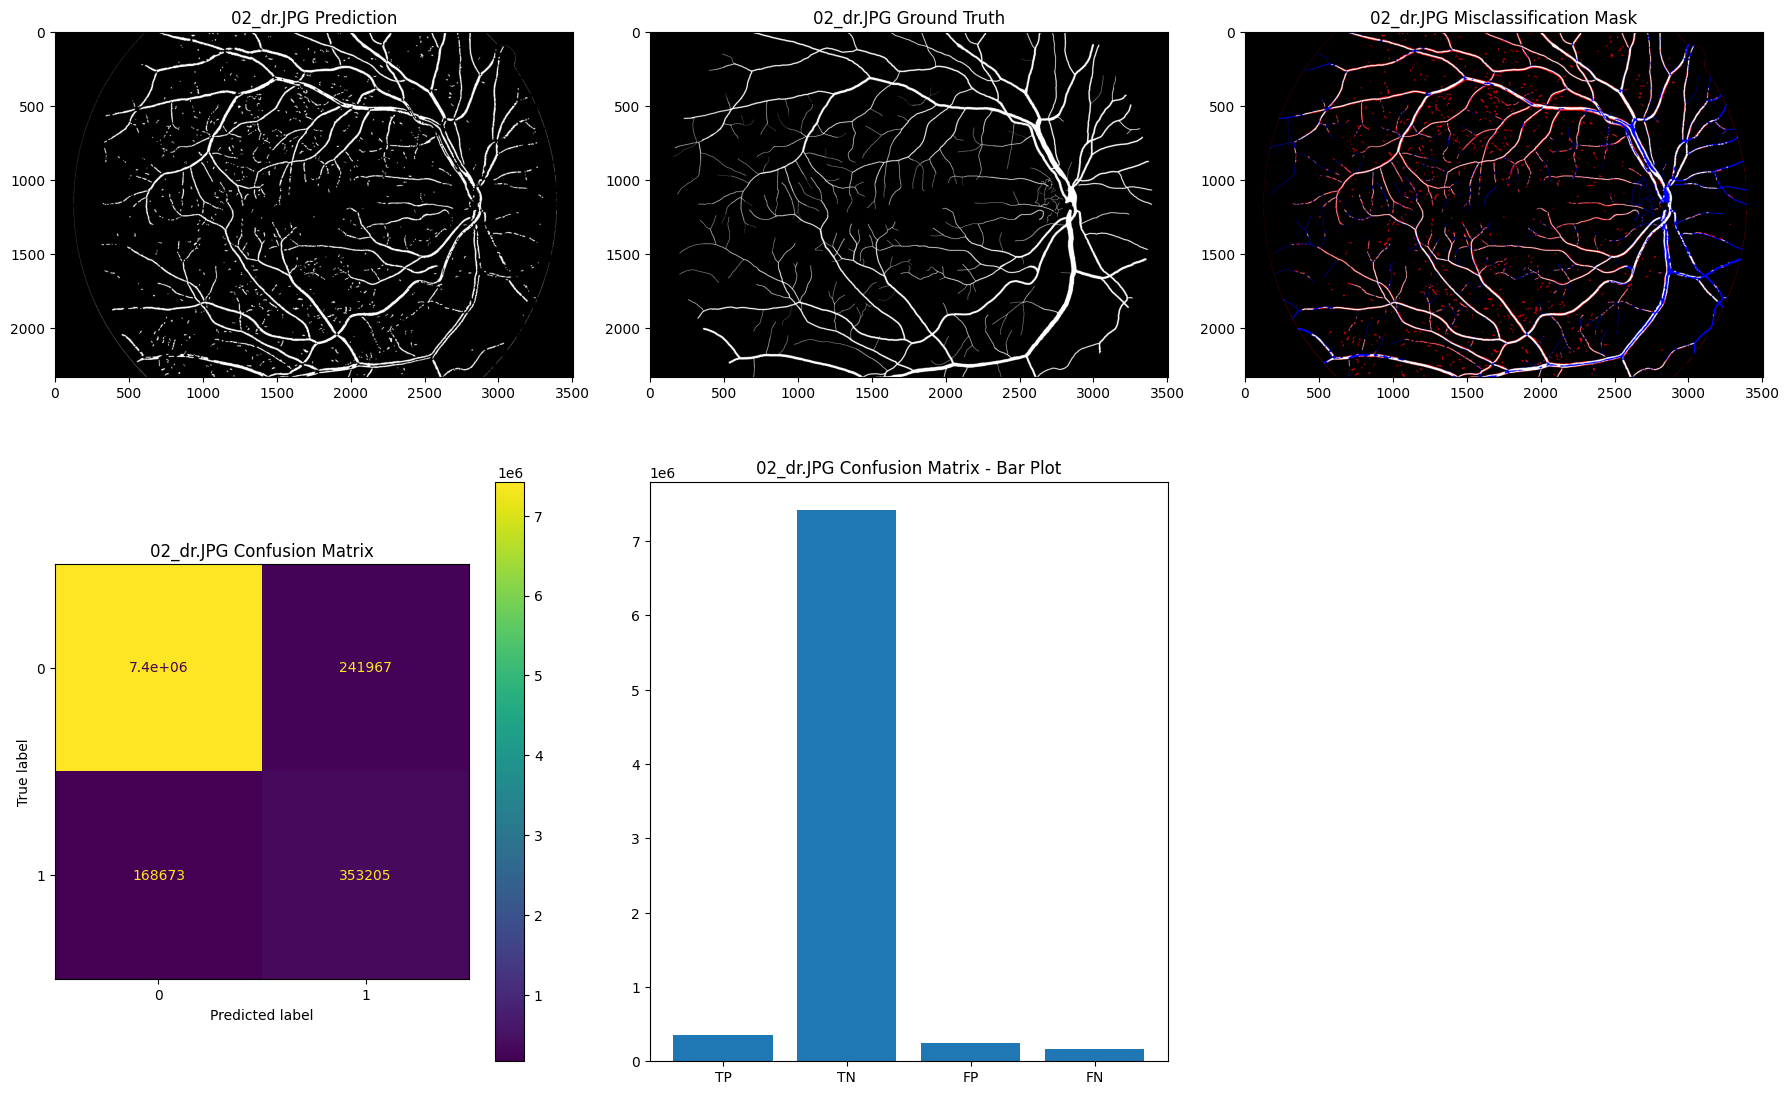

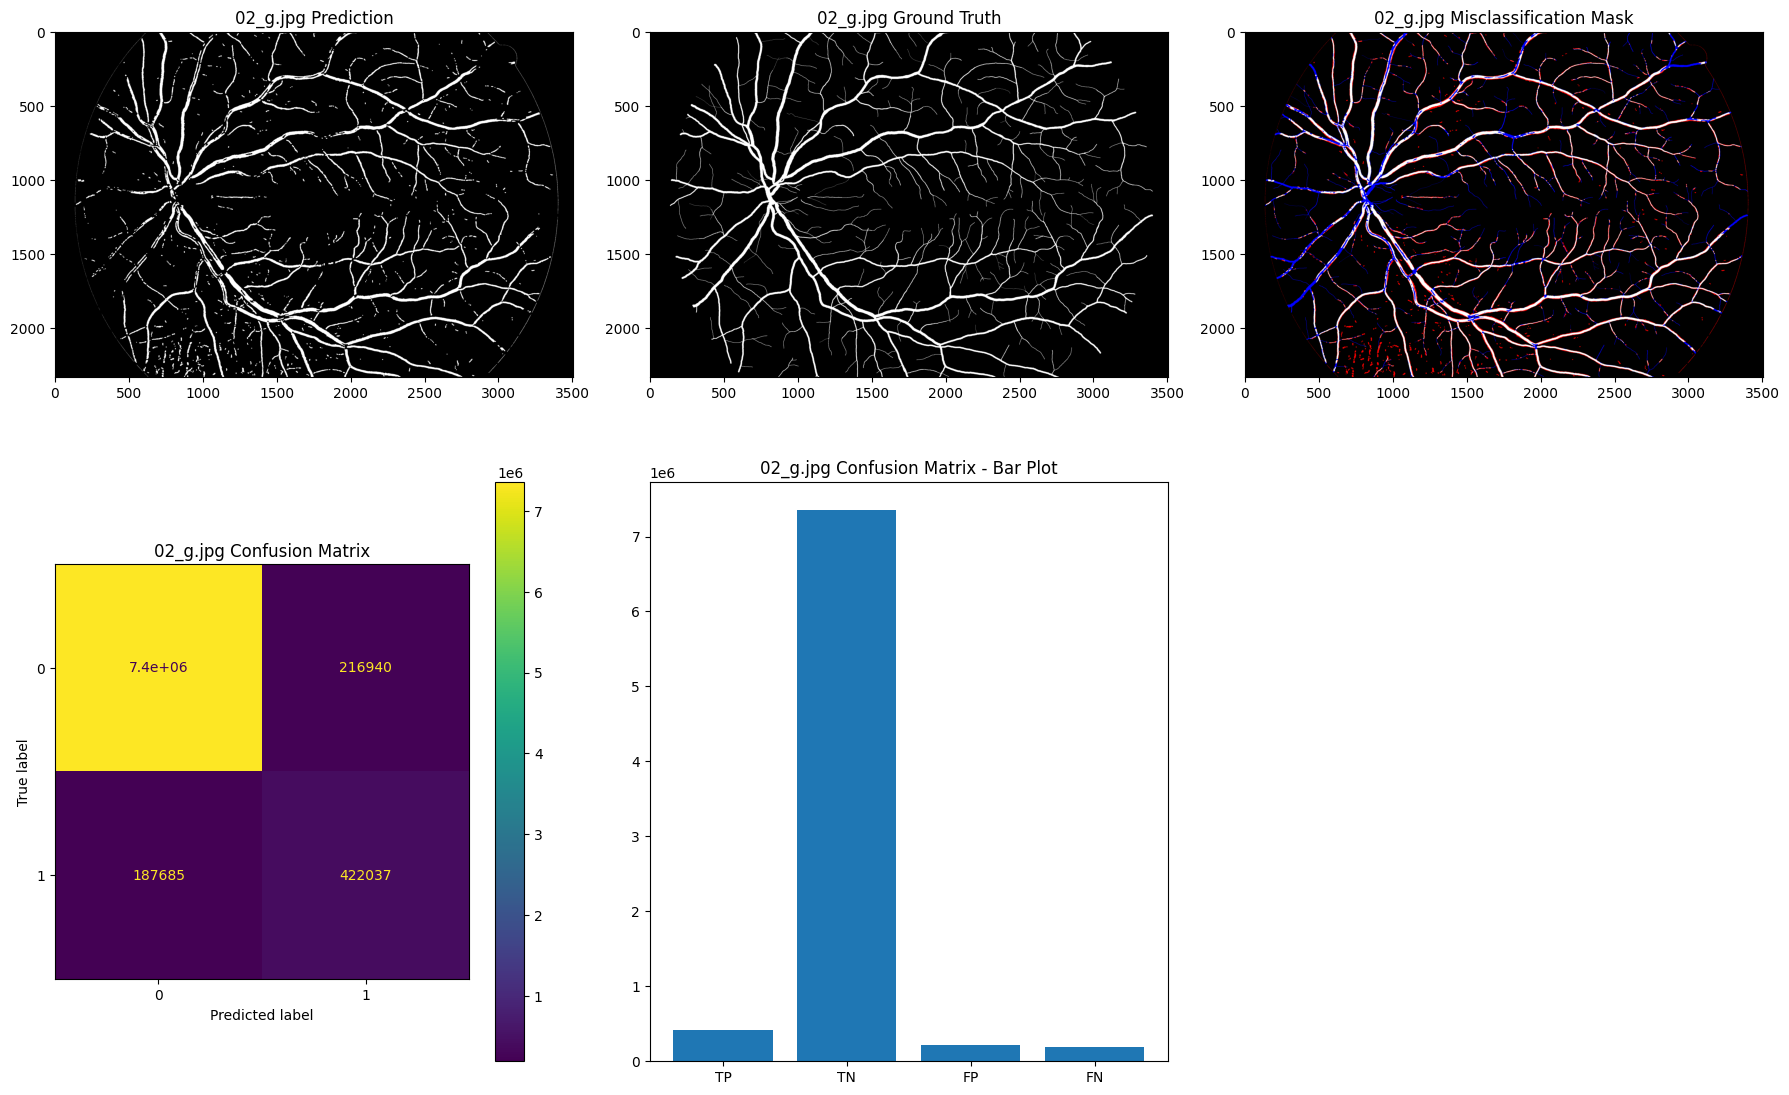

In [10]:
metrics_visualizer.visualize()

## Uzasadnienie zastosowanych metod
1. Ekstrakcja składowej zielonej: Wyodrębnienie składowej zielonej z obrazu może pomóc w usunięciu zakłóceń wynikających z innych składowych kolorów, które mogą utrudniać segmentację naczyń krwionośnych. Składowa zielona jest często używana w medycynie, ponieważ naczynia krwionośne mają wyższe nasycenie w tej składowej.

2. Zastosowanie rozmycia medianowego: Rozmycie medianowe pomaga w redukcji szumów i innych zakłóceń w obrazie. Szumy mogą utrudniać prawidłowe wykrywanie i segmentację naczyń krwionośnych. Rozmycie medianowe jest szczególnie skuteczne w usuwaniu impulsowych szumów, zachowując przy tym ostrość krawędzi.

3. Zastosowanie normalizacji histogramu: Normalizacja histogramu pozwala na wyrównanie rozkładu jasności obrazu, co może poprawić kontrast naczyń krwionośnych i ułatwić ich segmentację. Dzięki temu metoda może działać bardziej spójnie na różnych obrazach oka.

4. Filtr Frangiego: Filtr Frangiego jest specjalnie opracowanym filtrem do detekcji naczyń krwionośnych w obrazach biomedycznych. Jego działanie opiera się na wykrywaniu krawędzi i struktur typowych dla naczyń krwionośnych. Filtr ten może pomóc w uwypukleniu naczyń krwionośnych i redukcji innych zakłóceń w obrazie.

5. Otwarcie i rozmycie: Zastosowanie operacji otwarcia (erozja, a następnie dylatacja) może pomóc w usunięciu drobnych zakłóceń i zamknięciu luk między naczyniami krwionośnymi. Rozmycie po operacji otwarcia może dodatkowo wygładzić krawędzie i poprawić ciągłość segmentowanych naczyń.

6. Usunięcie małych obiektów: Usuwanie małych obiektów pozwala na odfiltrowanie nieistotnych elementów segmentacji, które mogą być fałszywymi pozytywami. Pozwala to uzyskać czystsze i bardziej precyzyjne segmentacje naczyń krwionośnych.

#### Podsumowanie
Wszystkie te metody łącznie przyczyniają się do poprawy jakości segmentacji naczyń krwionośnych. Usuwanie zakłóceń, poprawa kontrastu, uwypuklanie naczyń i eliminacja nieistotnych detekcji przyczyniają się do uzyskania dokładniejszego i bardziej wiarygodnego wyniku segmentacji.